## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../src_code')

import models
from train import *
from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 10
batch_size = 128
lr = 0.001
k = 3

target_net_type = models.mlleaks_cnn
shadow_net_type = models.mlleaks_cnn

## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


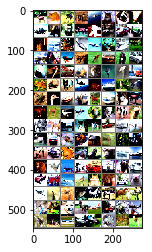

In [3]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    

    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [4]:

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

#attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

#attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = target_net_type().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type().to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = models.mlleaks_mlp(n_in=k).to(device)
attack_net.apply(models.weights_init)

#attack_loss = nn.BCEWithLogitsLoss()
attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)


In [5]:
train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs, classes=classes)

[0/10]
Accuracy of airplane : 65.60 %
Accuracy of automobile : 53.60 %
Accuracy of bird : 2.90 %
Accuracy of cat : 3.20 %
Accuracy of deer : 57.40 %
Accuracy of dog : 37.90 %
Accuracy of frog : 61.50 %
Accuracy of horse : 32.30 %
Accuracy of ship : 22.40 %
Accuracy of truck : 34.00 %

Total accuracy = 37.08 %


[1/10]
Accuracy of airplane : 47.90 %
Accuracy of automobile : 48.10 %
Accuracy of bird : 26.00 %
Accuracy of cat : 5.60 %
Accuracy of deer : 38.90 %
Accuracy of dog : 68.20 %
Accuracy of frog : 18.40 %
Accuracy of horse : 66.40 %
Accuracy of ship : 49.10 %
Accuracy of truck : 52.50 %

Total accuracy = 42.11 %


[2/10]
Accuracy of airplane : 66.60 %
Accuracy of automobile : 58.10 %
Accuracy of bird : 42.80 %
Accuracy of cat : 51.00 %
Accuracy of deer : 10.20 %
Accuracy of dog : 13.80 %
Accuracy of frog : 46.20 %
Accuracy of horse : 81.30 %
Accuracy of ship : 49.90 %
Accuracy of truck : 43.00 %

Total accuracy = 46.29 %


[3/10]
Accuracy of airplane : 79.00 %
Accuracy of automobi

In [6]:

train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, n_epochs=50, k=k)

[0/50][0/98] loss = 0.72, accuracy = 50.00
[0/50][1/98] loss = 0.71, accuracy = 50.00
[0/50][2/98] loss = 0.71, accuracy = 50.00
[0/50][3/98] loss = 0.71, accuracy = 50.00
[0/50][4/98] loss = 0.71, accuracy = 50.00
[0/50][5/98] loss = 0.71, accuracy = 50.00
[0/50][6/98] loss = 0.71, accuracy = 50.00
[0/50][7/98] loss = 0.70, accuracy = 50.00
[0/50][8/98] loss = 0.70, accuracy = 50.00
[0/50][9/98] loss = 0.70, accuracy = 50.00
[0/50][10/98] loss = 0.70, accuracy = 50.00
[0/50][11/98] loss = 0.70, accuracy = 50.00
[0/50][12/98] loss = 0.70, accuracy = 50.00
[0/50][13/98] loss = 0.70, accuracy = 50.00
[0/50][14/98] loss = 0.70, accuracy = 50.00
[0/50][15/98] loss = 0.70, accuracy = 50.00
[0/50][16/98] loss = 0.70, accuracy = 50.00
[0/50][17/98] loss = 0.70, accuracy = 50.00
[0/50][18/98] loss = 0.70, accuracy = 50.00
[0/50][19/98] loss = 0.70, accuracy = 50.00
[0/50][20/98] loss = 0.70, accuracy = 50.00
[0/50][21/98] loss = 0.70, accuracy = 50.00
[0/50][22/98] loss = 0.70, accuracy = 50.0

[1/50][89/98] loss = 0.69, accuracy = 50.88
[1/50][90/98] loss = 0.69, accuracy = 50.91
[1/50][91/98] loss = 0.69, accuracy = 50.96
[1/50][92/98] loss = 0.69, accuracy = 50.95
[1/50][93/98] loss = 0.69, accuracy = 50.92
[1/50][94/98] loss = 0.69, accuracy = 50.89
[1/50][95/98] loss = 0.69, accuracy = 50.88
[1/50][96/98] loss = 0.69, accuracy = 50.86
[1/50][97/98] loss = 0.69, accuracy = 50.86
[2/50][0/98] loss = 0.69, accuracy = 48.44
[2/50][1/98] loss = 0.69, accuracy = 49.80
[2/50][2/98] loss = 0.69, accuracy = 51.56
[2/50][3/98] loss = 0.69, accuracy = 50.59
[2/50][4/98] loss = 0.69, accuracy = 50.70
[2/50][5/98] loss = 0.69, accuracy = 50.26
[2/50][6/98] loss = 0.69, accuracy = 50.22
[2/50][7/98] loss = 0.69, accuracy = 50.20
[2/50][8/98] loss = 0.69, accuracy = 49.87
[2/50][9/98] loss = 0.69, accuracy = 50.27
[2/50][10/98] loss = 0.69, accuracy = 50.04
[2/50][11/98] loss = 0.69, accuracy = 50.39
[2/50][12/98] loss = 0.69, accuracy = 50.06
[2/50][13/98] loss = 0.69, accuracy = 50.1

[3/50][83/98] loss = 0.69, accuracy = 51.71
[3/50][84/98] loss = 0.69, accuracy = 51.69
[3/50][85/98] loss = 0.69, accuracy = 51.62
[3/50][86/98] loss = 0.69, accuracy = 51.65
[3/50][87/98] loss = 0.69, accuracy = 51.64
[3/50][88/98] loss = 0.69, accuracy = 51.72
[3/50][89/98] loss = 0.69, accuracy = 51.73
[3/50][90/98] loss = 0.69, accuracy = 51.71
[3/50][91/98] loss = 0.69, accuracy = 51.71
[3/50][92/98] loss = 0.69, accuracy = 51.72
[3/50][93/98] loss = 0.69, accuracy = 51.72
[3/50][94/98] loss = 0.69, accuracy = 51.65
[3/50][95/98] loss = 0.69, accuracy = 51.61
[3/50][96/98] loss = 0.69, accuracy = 51.62
[3/50][97/98] loss = 0.69, accuracy = 51.63
[4/50][0/98] loss = 0.69, accuracy = 47.66
[4/50][1/98] loss = 0.69, accuracy = 50.78
[4/50][2/98] loss = 0.69, accuracy = 51.43
[4/50][3/98] loss = 0.69, accuracy = 50.29
[4/50][4/98] loss = 0.69, accuracy = 50.39
[4/50][5/98] loss = 0.69, accuracy = 50.26
[4/50][6/98] loss = 0.69, accuracy = 50.28
[4/50][7/98] loss = 0.69, accuracy = 50

[5/50][78/98] loss = 0.70, accuracy = 52.05
[5/50][79/98] loss = 0.69, accuracy = 52.01
[5/50][80/98] loss = 0.69, accuracy = 52.03
[5/50][81/98] loss = 0.69, accuracy = 52.03
[5/50][82/98] loss = 0.69, accuracy = 52.08
[5/50][83/98] loss = 0.69, accuracy = 52.12
[5/50][84/98] loss = 0.69, accuracy = 52.07
[5/50][85/98] loss = 0.69, accuracy = 52.06
[5/50][86/98] loss = 0.69, accuracy = 52.08
[5/50][87/98] loss = 0.69, accuracy = 52.10
[5/50][88/98] loss = 0.69, accuracy = 52.11
[5/50][89/98] loss = 0.69, accuracy = 52.12
[5/50][90/98] loss = 0.69, accuracy = 52.12
[5/50][91/98] loss = 0.69, accuracy = 52.10
[5/50][92/98] loss = 0.69, accuracy = 52.07
[5/50][93/98] loss = 0.69, accuracy = 52.08
[5/50][94/98] loss = 0.69, accuracy = 52.09
[5/50][95/98] loss = 0.69, accuracy = 52.07
[5/50][96/98] loss = 0.69, accuracy = 52.01
[5/50][97/98] loss = 0.69, accuracy = 52.02
[6/50][0/98] loss = 0.69, accuracy = 51.17
[6/50][1/98] loss = 0.69, accuracy = 51.95
[6/50][2/98] loss = 0.69, accuracy

[7/50][71/98] loss = 0.69, accuracy = 52.39
[7/50][72/98] loss = 0.69, accuracy = 52.39
[7/50][73/98] loss = 0.69, accuracy = 52.40
[7/50][74/98] loss = 0.69, accuracy = 52.36
[7/50][75/98] loss = 0.69, accuracy = 52.33
[7/50][76/98] loss = 0.70, accuracy = 52.30
[7/50][77/98] loss = 0.69, accuracy = 52.30
[7/50][78/98] loss = 0.69, accuracy = 52.35
[7/50][79/98] loss = 0.69, accuracy = 52.44
[7/50][80/98] loss = 0.69, accuracy = 52.44
[7/50][81/98] loss = 0.69, accuracy = 52.44
[7/50][82/98] loss = 0.69, accuracy = 52.45
[7/50][83/98] loss = 0.69, accuracy = 52.46
[7/50][84/98] loss = 0.69, accuracy = 52.47
[7/50][85/98] loss = 0.69, accuracy = 52.52
[7/50][86/98] loss = 0.69, accuracy = 52.46
[7/50][87/98] loss = 0.69, accuracy = 52.44
[7/50][88/98] loss = 0.69, accuracy = 52.45
[7/50][89/98] loss = 0.69, accuracy = 52.45
[7/50][90/98] loss = 0.69, accuracy = 52.51
[7/50][91/98] loss = 0.69, accuracy = 52.49
[7/50][92/98] loss = 0.69, accuracy = 52.49
[7/50][93/98] loss = 0.69, accur

[9/50][67/98] loss = 0.69, accuracy = 52.60
[9/50][68/98] loss = 0.69, accuracy = 52.64
[9/50][69/98] loss = 0.69, accuracy = 52.57
[9/50][70/98] loss = 0.69, accuracy = 52.57
[9/50][71/98] loss = 0.69, accuracy = 52.55
[9/50][72/98] loss = 0.69, accuracy = 52.50
[9/50][73/98] loss = 0.69, accuracy = 52.51
[9/50][74/98] loss = 0.69, accuracy = 52.47
[9/50][75/98] loss = 0.69, accuracy = 52.48
[9/50][76/98] loss = 0.69, accuracy = 52.49
[9/50][77/98] loss = 0.69, accuracy = 52.52
[9/50][78/98] loss = 0.69, accuracy = 52.52
[9/50][79/98] loss = 0.69, accuracy = 52.50
[9/50][80/98] loss = 0.69, accuracy = 52.48
[9/50][81/98] loss = 0.69, accuracy = 52.44
[9/50][82/98] loss = 0.69, accuracy = 52.45
[9/50][83/98] loss = 0.69, accuracy = 52.41
[9/50][84/98] loss = 0.69, accuracy = 52.41
[9/50][85/98] loss = 0.69, accuracy = 52.43
[9/50][86/98] loss = 0.69, accuracy = 52.48
[9/50][87/98] loss = 0.69, accuracy = 52.52
[9/50][88/98] loss = 0.69, accuracy = 52.57
[9/50][89/98] loss = 0.69, accur

[11/50][59/98] loss = 0.69, accuracy = 52.55
[11/50][60/98] loss = 0.69, accuracy = 52.57
[11/50][61/98] loss = 0.69, accuracy = 52.51
[11/50][62/98] loss = 0.69, accuracy = 52.57
[11/50][63/98] loss = 0.69, accuracy = 52.51
[11/50][64/98] loss = 0.69, accuracy = 52.46
[11/50][65/98] loss = 0.69, accuracy = 52.46
[11/50][66/98] loss = 0.69, accuracy = 52.49
[11/50][67/98] loss = 0.69, accuracy = 52.48
[11/50][68/98] loss = 0.69, accuracy = 52.50
[11/50][69/98] loss = 0.69, accuracy = 52.49
[11/50][70/98] loss = 0.69, accuracy = 52.54
[11/50][71/98] loss = 0.70, accuracy = 52.50
[11/50][72/98] loss = 0.69, accuracy = 52.47
[11/50][73/98] loss = 0.69, accuracy = 52.39
[11/50][74/98] loss = 0.69, accuracy = 52.41
[11/50][75/98] loss = 0.69, accuracy = 52.37
[11/50][76/98] loss = 0.69, accuracy = 52.35
[11/50][77/98] loss = 0.69, accuracy = 52.37
[11/50][78/98] loss = 0.69, accuracy = 52.33
[11/50][79/98] loss = 0.69, accuracy = 52.35
[11/50][80/98] loss = 0.69, accuracy = 52.31
[11/50][81

[13/50][49/98] loss = 0.70, accuracy = 52.32
[13/50][50/98] loss = 0.70, accuracy = 52.14
[13/50][51/98] loss = 0.69, accuracy = 52.19
[13/50][52/98] loss = 0.69, accuracy = 52.28
[13/50][53/98] loss = 0.69, accuracy = 52.27
[13/50][54/98] loss = 0.69, accuracy = 52.29
[13/50][55/98] loss = 0.69, accuracy = 52.30
[13/50][56/98] loss = 0.70, accuracy = 52.28
[13/50][57/98] loss = 0.69, accuracy = 52.29
[13/50][58/98] loss = 0.69, accuracy = 52.32
[13/50][59/98] loss = 0.69, accuracy = 52.25
[13/50][60/98] loss = 0.69, accuracy = 52.27
[13/50][61/98] loss = 0.69, accuracy = 52.28
[13/50][62/98] loss = 0.69, accuracy = 52.27
[13/50][63/98] loss = 0.69, accuracy = 52.36
[13/50][64/98] loss = 0.69, accuracy = 52.39
[13/50][65/98] loss = 0.69, accuracy = 52.38
[13/50][66/98] loss = 0.69, accuracy = 52.40
[13/50][67/98] loss = 0.69, accuracy = 52.39
[13/50][68/98] loss = 0.69, accuracy = 52.34
[13/50][69/98] loss = 0.69, accuracy = 52.35
[13/50][70/98] loss = 0.69, accuracy = 52.35
[13/50][71

[15/50][39/98] loss = 0.69, accuracy = 52.59
[15/50][40/98] loss = 0.69, accuracy = 52.63
[15/50][41/98] loss = 0.69, accuracy = 52.71
[15/50][42/98] loss = 0.69, accuracy = 52.71
[15/50][43/98] loss = 0.69, accuracy = 52.81
[15/50][44/98] loss = 0.69, accuracy = 52.93
[15/50][45/98] loss = 0.69, accuracy = 52.98
[15/50][46/98] loss = 0.69, accuracy = 52.95
[15/50][47/98] loss = 0.69, accuracy = 53.03
[15/50][48/98] loss = 0.69, accuracy = 53.00
[15/50][49/98] loss = 0.69, accuracy = 53.11
[15/50][50/98] loss = 0.69, accuracy = 53.08
[15/50][51/98] loss = 0.69, accuracy = 53.13
[15/50][52/98] loss = 0.69, accuracy = 53.14
[15/50][53/98] loss = 0.69, accuracy = 53.12
[15/50][54/98] loss = 0.69, accuracy = 53.15
[15/50][55/98] loss = 0.69, accuracy = 53.14
[15/50][56/98] loss = 0.69, accuracy = 53.10
[15/50][57/98] loss = 0.69, accuracy = 53.15
[15/50][58/98] loss = 0.69, accuracy = 53.18
[15/50][59/98] loss = 0.69, accuracy = 53.21
[15/50][60/98] loss = 0.69, accuracy = 53.19
[15/50][61

[17/50][26/98] loss = 0.69, accuracy = 52.20
[17/50][27/98] loss = 0.69, accuracy = 52.19
[17/50][28/98] loss = 0.69, accuracy = 52.13
[17/50][29/98] loss = 0.69, accuracy = 52.17
[17/50][30/98] loss = 0.69, accuracy = 52.21
[17/50][31/98] loss = 0.69, accuracy = 52.27
[17/50][32/98] loss = 0.69, accuracy = 52.18
[17/50][33/98] loss = 0.69, accuracy = 52.24
[17/50][34/98] loss = 0.69, accuracy = 52.38
[17/50][35/98] loss = 0.69, accuracy = 52.46
[17/50][36/98] loss = 0.69, accuracy = 52.49
[17/50][37/98] loss = 0.69, accuracy = 52.54
[17/50][38/98] loss = 0.69, accuracy = 52.54
[17/50][39/98] loss = 0.70, accuracy = 52.43
[17/50][40/98] loss = 0.69, accuracy = 52.57
[17/50][41/98] loss = 0.69, accuracy = 52.57
[17/50][42/98] loss = 0.69, accuracy = 52.50
[17/50][43/98] loss = 0.69, accuracy = 52.51
[17/50][44/98] loss = 0.69, accuracy = 52.43
[17/50][45/98] loss = 0.69, accuracy = 52.41
[17/50][46/98] loss = 0.69, accuracy = 52.39
[17/50][47/98] loss = 0.70, accuracy = 52.25
[17/50][48

[19/50][13/98] loss = 0.69, accuracy = 53.24
[19/50][14/98] loss = 0.70, accuracy = 52.94
[19/50][15/98] loss = 0.69, accuracy = 52.81
[19/50][16/98] loss = 0.70, accuracy = 52.53
[19/50][17/98] loss = 0.69, accuracy = 52.82
[19/50][18/98] loss = 0.69, accuracy = 52.84
[19/50][19/98] loss = 0.69, accuracy = 53.11
[19/50][20/98] loss = 0.70, accuracy = 52.75
[19/50][21/98] loss = 0.69, accuracy = 52.81
[19/50][22/98] loss = 0.70, accuracy = 52.45
[19/50][23/98] loss = 0.69, accuracy = 52.60
[19/50][24/98] loss = 0.69, accuracy = 52.66
[19/50][25/98] loss = 0.69, accuracy = 52.72
[19/50][26/98] loss = 0.69, accuracy = 52.76
[19/50][27/98] loss = 0.69, accuracy = 52.58
[19/50][28/98] loss = 0.69, accuracy = 52.69
[19/50][29/98] loss = 0.70, accuracy = 52.54
[19/50][30/98] loss = 0.69, accuracy = 52.80
[19/50][31/98] loss = 0.69, accuracy = 52.77
[19/50][32/98] loss = 0.69, accuracy = 52.69
[19/50][33/98] loss = 0.69, accuracy = 52.69
[19/50][34/98] loss = 0.69, accuracy = 52.59
[19/50][35

[21/50][0/98] loss = 0.69, accuracy = 53.52
[21/50][1/98] loss = 0.69, accuracy = 51.95
[21/50][2/98] loss = 0.70, accuracy = 50.78
[21/50][3/98] loss = 0.69, accuracy = 52.64
[21/50][4/98] loss = 0.69, accuracy = 52.11
[21/50][5/98] loss = 0.69, accuracy = 51.89
[21/50][6/98] loss = 0.69, accuracy = 51.67
[21/50][7/98] loss = 0.69, accuracy = 51.22
[21/50][8/98] loss = 0.69, accuracy = 51.35
[21/50][9/98] loss = 0.70, accuracy = 50.98
[21/50][10/98] loss = 0.69, accuracy = 50.92
[21/50][11/98] loss = 0.69, accuracy = 51.07
[21/50][12/98] loss = 0.69, accuracy = 51.41
[21/50][13/98] loss = 0.69, accuracy = 51.67
[21/50][14/98] loss = 0.69, accuracy = 51.67
[21/50][15/98] loss = 0.69, accuracy = 51.61
[21/50][16/98] loss = 0.69, accuracy = 51.59
[21/50][17/98] loss = 0.69, accuracy = 51.89
[21/50][18/98] loss = 0.69, accuracy = 51.99
[21/50][19/98] loss = 0.69, accuracy = 52.09
[21/50][20/98] loss = 0.69, accuracy = 52.03
[21/50][21/98] loss = 0.69, accuracy = 52.22
[21/50][22/98] loss 

[22/50][86/98] loss = 0.69, accuracy = 52.79
[22/50][87/98] loss = 0.70, accuracy = 52.75
[22/50][88/98] loss = 0.69, accuracy = 52.70
[22/50][89/98] loss = 0.69, accuracy = 52.70
[22/50][90/98] loss = 0.69, accuracy = 52.70
[22/50][91/98] loss = 0.69, accuracy = 52.69
[22/50][92/98] loss = 0.69, accuracy = 52.65
[22/50][93/98] loss = 0.69, accuracy = 52.65
[22/50][94/98] loss = 0.69, accuracy = 52.67
[22/50][95/98] loss = 0.69, accuracy = 52.65
[22/50][96/98] loss = 0.69, accuracy = 52.62
[22/50][97/98] loss = 0.70, accuracy = 52.60
[23/50][0/98] loss = 0.69, accuracy = 54.30
[23/50][1/98] loss = 0.70, accuracy = 52.34
[23/50][2/98] loss = 0.69, accuracy = 52.08
[23/50][3/98] loss = 0.69, accuracy = 51.56
[23/50][4/98] loss = 0.69, accuracy = 52.81
[23/50][5/98] loss = 0.69, accuracy = 51.89
[23/50][6/98] loss = 0.69, accuracy = 52.01
[23/50][7/98] loss = 0.69, accuracy = 51.56
[23/50][8/98] loss = 0.70, accuracy = 51.35
[23/50][9/98] loss = 0.69, accuracy = 51.37
[23/50][10/98] loss 

[24/50][73/98] loss = 0.69, accuracy = 52.24
[24/50][74/98] loss = 0.69, accuracy = 52.32
[24/50][75/98] loss = 0.69, accuracy = 52.32
[24/50][76/98] loss = 0.68, accuracy = 52.43
[24/50][77/98] loss = 0.70, accuracy = 52.34
[24/50][78/98] loss = 0.69, accuracy = 52.38
[24/50][79/98] loss = 0.69, accuracy = 52.40
[24/50][80/98] loss = 0.69, accuracy = 52.36
[24/50][81/98] loss = 0.69, accuracy = 52.37
[24/50][82/98] loss = 0.69, accuracy = 52.36
[24/50][83/98] loss = 0.69, accuracy = 52.37
[24/50][84/98] loss = 0.69, accuracy = 52.34
[24/50][85/98] loss = 0.69, accuracy = 52.33
[24/50][86/98] loss = 0.69, accuracy = 52.35
[24/50][87/98] loss = 0.69, accuracy = 52.34
[24/50][88/98] loss = 0.69, accuracy = 52.34
[24/50][89/98] loss = 0.69, accuracy = 52.31
[24/50][90/98] loss = 0.69, accuracy = 52.34
[24/50][91/98] loss = 0.70, accuracy = 52.30
[24/50][92/98] loss = 0.69, accuracy = 52.34
[24/50][93/98] loss = 0.69, accuracy = 52.33
[24/50][94/98] loss = 0.69, accuracy = 52.32
[24/50][95

[26/50][63/98] loss = 0.69, accuracy = 52.37
[26/50][64/98] loss = 0.69, accuracy = 52.40
[26/50][65/98] loss = 0.69, accuracy = 52.40
[26/50][66/98] loss = 0.69, accuracy = 52.39
[26/50][67/98] loss = 0.69, accuracy = 52.41
[26/50][68/98] loss = 0.69, accuracy = 52.41
[26/50][69/98] loss = 0.70, accuracy = 52.30
[26/50][70/98] loss = 0.69, accuracy = 52.31
[26/50][71/98] loss = 0.69, accuracy = 52.28
[26/50][72/98] loss = 0.69, accuracy = 52.22
[26/50][73/98] loss = 0.69, accuracy = 52.28
[26/50][74/98] loss = 0.69, accuracy = 52.26
[26/50][75/98] loss = 0.69, accuracy = 52.30
[26/50][76/98] loss = 0.69, accuracy = 52.33
[26/50][77/98] loss = 0.69, accuracy = 52.37
[26/50][78/98] loss = 0.69, accuracy = 52.40
[26/50][79/98] loss = 0.69, accuracy = 52.40
[26/50][80/98] loss = 0.69, accuracy = 52.47
[26/50][81/98] loss = 0.69, accuracy = 52.47
[26/50][82/98] loss = 0.70, accuracy = 52.43
[26/50][83/98] loss = 0.69, accuracy = 52.40
[26/50][84/98] loss = 0.69, accuracy = 52.46
[26/50][85

[28/50][53/98] loss = 0.69, accuracy = 52.43
[28/50][54/98] loss = 0.69, accuracy = 52.49
[28/50][55/98] loss = 0.69, accuracy = 52.63
[28/50][56/98] loss = 0.69, accuracy = 52.61
[28/50][57/98] loss = 0.69, accuracy = 52.62
[28/50][58/98] loss = 0.70, accuracy = 52.52
[28/50][59/98] loss = 0.69, accuracy = 52.58
[28/50][60/98] loss = 0.69, accuracy = 52.54
[28/50][61/98] loss = 0.69, accuracy = 52.54
[28/50][62/98] loss = 0.69, accuracy = 52.58
[28/50][63/98] loss = 0.69, accuracy = 52.53
[28/50][64/98] loss = 0.69, accuracy = 52.52
[28/50][65/98] loss = 0.69, accuracy = 52.60
[28/50][66/98] loss = 0.69, accuracy = 52.62
[28/50][67/98] loss = 0.69, accuracy = 52.63
[28/50][68/98] loss = 0.69, accuracy = 52.64
[28/50][69/98] loss = 0.69, accuracy = 52.68
[28/50][70/98] loss = 0.69, accuracy = 52.70
[28/50][71/98] loss = 0.69, accuracy = 52.71
[28/50][72/98] loss = 0.69, accuracy = 52.70
[28/50][73/98] loss = 0.69, accuracy = 52.67
[28/50][74/98] loss = 0.69, accuracy = 52.68
[28/50][75

[30/50][48/98] loss = 0.69, accuracy = 52.25
[30/50][49/98] loss = 0.69, accuracy = 52.22
[30/50][50/98] loss = 0.70, accuracy = 52.14
[30/50][51/98] loss = 0.69, accuracy = 52.25
[30/50][52/98] loss = 0.70, accuracy = 52.16
[30/50][53/98] loss = 0.69, accuracy = 52.21
[30/50][54/98] loss = 0.69, accuracy = 52.31
[30/50][55/98] loss = 0.69, accuracy = 52.39
[30/50][56/98] loss = 0.69, accuracy = 52.41
[30/50][57/98] loss = 0.69, accuracy = 52.46
[30/50][58/98] loss = 0.69, accuracy = 52.50
[30/50][59/98] loss = 0.70, accuracy = 52.40
[30/50][60/98] loss = 0.69, accuracy = 52.40
[30/50][61/98] loss = 0.68, accuracy = 52.55
[30/50][62/98] loss = 0.69, accuracy = 52.49
[30/50][63/98] loss = 0.69, accuracy = 52.51
[30/50][64/98] loss = 0.70, accuracy = 52.45
[30/50][65/98] loss = 0.69, accuracy = 52.52
[30/50][66/98] loss = 0.69, accuracy = 52.54
[30/50][67/98] loss = 0.69, accuracy = 52.52
[30/50][68/98] loss = 0.70, accuracy = 52.46
[30/50][69/98] loss = 0.68, accuracy = 52.55
[30/50][70

[32/50][38/98] loss = 0.69, accuracy = 52.87
[32/50][39/98] loss = 0.69, accuracy = 52.85
[32/50][40/98] loss = 0.69, accuracy = 52.83
[32/50][41/98] loss = 0.69, accuracy = 52.96
[32/50][42/98] loss = 0.69, accuracy = 52.98
[32/50][43/98] loss = 0.70, accuracy = 52.97
[32/50][44/98] loss = 0.70, accuracy = 52.74
[32/50][45/98] loss = 0.69, accuracy = 52.73
[32/50][46/98] loss = 0.70, accuracy = 52.65
[32/50][47/98] loss = 0.69, accuracy = 52.71
[32/50][48/98] loss = 0.69, accuracy = 52.77
[32/50][49/98] loss = 0.69, accuracy = 52.74
[32/50][50/98] loss = 0.69, accuracy = 52.77
[32/50][51/98] loss = 0.69, accuracy = 52.76
[32/50][52/98] loss = 0.69, accuracy = 52.83
[32/50][53/98] loss = 0.69, accuracy = 52.79
[32/50][54/98] loss = 0.69, accuracy = 52.75
[32/50][55/98] loss = 0.69, accuracy = 52.75
[32/50][56/98] loss = 0.69, accuracy = 52.71
[32/50][57/98] loss = 0.69, accuracy = 52.74
[32/50][58/98] loss = 0.69, accuracy = 52.84
[32/50][59/98] loss = 0.69, accuracy = 52.88
[32/50][60

[34/50][28/98] loss = 0.69, accuracy = 52.84
[34/50][29/98] loss = 0.69, accuracy = 52.93
[34/50][30/98] loss = 0.69, accuracy = 52.89
[34/50][31/98] loss = 0.69, accuracy = 53.02
[34/50][32/98] loss = 0.69, accuracy = 52.98
[34/50][33/98] loss = 0.69, accuracy = 52.94
[34/50][34/98] loss = 0.69, accuracy = 52.81
[34/50][35/98] loss = 0.69, accuracy = 52.76
[34/50][36/98] loss = 0.69, accuracy = 52.76
[34/50][37/98] loss = 0.69, accuracy = 52.75
[34/50][38/98] loss = 0.70, accuracy = 52.68
[34/50][39/98] loss = 0.69, accuracy = 52.73
[34/50][40/98] loss = 0.70, accuracy = 52.65
[34/50][41/98] loss = 0.69, accuracy = 52.61
[34/50][42/98] loss = 0.69, accuracy = 52.57
[34/50][43/98] loss = 0.69, accuracy = 52.53
[34/50][44/98] loss = 0.69, accuracy = 52.52
[34/50][45/98] loss = 0.69, accuracy = 52.51
[34/50][46/98] loss = 0.69, accuracy = 52.47
[34/50][47/98] loss = 0.69, accuracy = 52.59
[34/50][48/98] loss = 0.69, accuracy = 52.62
[34/50][49/98] loss = 0.69, accuracy = 52.55
[34/50][50

[36/50][21/98] loss = 0.69, accuracy = 53.32
[36/50][22/98] loss = 0.70, accuracy = 52.97
[36/50][23/98] loss = 0.69, accuracy = 52.98
[36/50][24/98] loss = 0.70, accuracy = 52.75
[36/50][25/98] loss = 0.69, accuracy = 52.87
[36/50][26/98] loss = 0.70, accuracy = 52.72
[36/50][27/98] loss = 0.69, accuracy = 52.75
[36/50][28/98] loss = 0.70, accuracy = 52.57
[36/50][29/98] loss = 0.69, accuracy = 52.70
[36/50][30/98] loss = 0.69, accuracy = 52.68
[36/50][31/98] loss = 0.69, accuracy = 52.65
[36/50][32/98] loss = 0.69, accuracy = 52.62
[36/50][33/98] loss = 0.70, accuracy = 52.40
[36/50][34/98] loss = 0.69, accuracy = 52.51
[36/50][35/98] loss = 0.69, accuracy = 52.51
[36/50][36/98] loss = 0.69, accuracy = 52.43
[36/50][37/98] loss = 0.69, accuracy = 52.48
[36/50][38/98] loss = 0.69, accuracy = 52.51
[36/50][39/98] loss = 0.69, accuracy = 52.49
[36/50][40/98] loss = 0.69, accuracy = 52.49
[36/50][41/98] loss = 0.70, accuracy = 52.37
[36/50][42/98] loss = 0.69, accuracy = 52.36
[36/50][43

[38/50][9/98] loss = 0.69, accuracy = 51.91
[38/50][10/98] loss = 0.69, accuracy = 52.24
[38/50][11/98] loss = 0.69, accuracy = 52.21
[38/50][12/98] loss = 0.69, accuracy = 52.13
[38/50][13/98] loss = 0.69, accuracy = 52.20
[38/50][14/98] loss = 0.69, accuracy = 52.19
[38/50][15/98] loss = 0.69, accuracy = 52.54
[38/50][16/98] loss = 0.69, accuracy = 52.55
[38/50][17/98] loss = 0.69, accuracy = 52.43
[38/50][18/98] loss = 0.69, accuracy = 52.57
[38/50][19/98] loss = 0.69, accuracy = 52.83
[38/50][20/98] loss = 0.69, accuracy = 52.77
[38/50][21/98] loss = 0.69, accuracy = 52.86
[38/50][22/98] loss = 0.69, accuracy = 52.90
[38/50][23/98] loss = 0.69, accuracy = 53.03
[38/50][24/98] loss = 0.69, accuracy = 52.86
[38/50][25/98] loss = 0.69, accuracy = 52.96
[38/50][26/98] loss = 0.69, accuracy = 53.02
[38/50][27/98] loss = 0.69, accuracy = 53.15
[38/50][28/98] loss = 0.69, accuracy = 53.26
[38/50][29/98] loss = 0.69, accuracy = 53.18
[38/50][30/98] loss = 0.69, accuracy = 53.07
[38/50][31/

[40/50][0/98] loss = 0.69, accuracy = 51.95
[40/50][1/98] loss = 0.69, accuracy = 51.17
[40/50][2/98] loss = 0.69, accuracy = 51.04
[40/50][3/98] loss = 0.70, accuracy = 50.20
[40/50][4/98] loss = 0.69, accuracy = 50.31
[40/50][5/98] loss = 0.69, accuracy = 50.52
[40/50][6/98] loss = 0.70, accuracy = 50.61
[40/50][7/98] loss = 0.69, accuracy = 51.07
[40/50][8/98] loss = 0.69, accuracy = 51.13
[40/50][9/98] loss = 0.69, accuracy = 51.68
[40/50][10/98] loss = 0.69, accuracy = 51.63
[40/50][11/98] loss = 0.70, accuracy = 51.17
[40/50][12/98] loss = 0.69, accuracy = 51.50
[40/50][13/98] loss = 0.70, accuracy = 50.95
[40/50][14/98] loss = 0.69, accuracy = 50.99
[40/50][15/98] loss = 0.69, accuracy = 50.98
[40/50][16/98] loss = 0.69, accuracy = 51.26
[40/50][17/98] loss = 0.69, accuracy = 51.56
[40/50][18/98] loss = 0.69, accuracy = 51.52
[40/50][19/98] loss = 0.69, accuracy = 51.95
[40/50][20/98] loss = 0.69, accuracy = 51.88
[40/50][21/98] loss = 0.69, accuracy = 51.90
[40/50][22/98] loss 

[41/50][85/98] loss = 0.69, accuracy = 52.56
[41/50][86/98] loss = 0.69, accuracy = 52.57
[41/50][87/98] loss = 0.70, accuracy = 52.55
[41/50][88/98] loss = 0.69, accuracy = 52.54
[41/50][89/98] loss = 0.69, accuracy = 52.56
[41/50][90/98] loss = 0.69, accuracy = 52.54
[41/50][91/98] loss = 0.70, accuracy = 52.51
[41/50][92/98] loss = 0.69, accuracy = 52.49
[41/50][93/98] loss = 0.70, accuracy = 52.43
[41/50][94/98] loss = 0.69, accuracy = 52.47
[41/50][95/98] loss = 0.69, accuracy = 52.48
[41/50][96/98] loss = 0.69, accuracy = 52.53
[41/50][97/98] loss = 0.69, accuracy = 52.52
[42/50][0/98] loss = 0.69, accuracy = 51.17
[42/50][1/98] loss = 0.69, accuracy = 53.12
[42/50][2/98] loss = 0.69, accuracy = 52.60
[42/50][3/98] loss = 0.70, accuracy = 51.66
[42/50][4/98] loss = 0.69, accuracy = 51.48
[42/50][5/98] loss = 0.69, accuracy = 52.41
[42/50][6/98] loss = 0.70, accuracy = 51.79
[42/50][7/98] loss = 0.69, accuracy = 51.81
[42/50][8/98] loss = 0.69, accuracy = 52.30
[42/50][9/98] loss 

[43/50][72/98] loss = 0.70, accuracy = 52.54
[43/50][73/98] loss = 0.69, accuracy = 52.56
[43/50][74/98] loss = 0.69, accuracy = 52.59
[43/50][75/98] loss = 0.69, accuracy = 52.62
[43/50][76/98] loss = 0.69, accuracy = 52.65
[43/50][77/98] loss = 0.70, accuracy = 52.58
[43/50][78/98] loss = 0.69, accuracy = 52.61
[43/50][79/98] loss = 0.69, accuracy = 52.67
[43/50][80/98] loss = 0.70, accuracy = 52.63
[43/50][81/98] loss = 0.69, accuracy = 52.67
[43/50][82/98] loss = 0.69, accuracy = 52.72
[43/50][83/98] loss = 0.69, accuracy = 52.69
[43/50][84/98] loss = 0.69, accuracy = 52.74
[43/50][85/98] loss = 0.69, accuracy = 52.73
[43/50][86/98] loss = 0.69, accuracy = 52.75
[43/50][87/98] loss = 0.69, accuracy = 52.74
[43/50][88/98] loss = 0.69, accuracy = 52.72
[43/50][89/98] loss = 0.69, accuracy = 52.76
[43/50][90/98] loss = 0.69, accuracy = 52.80
[43/50][91/98] loss = 0.70, accuracy = 52.70
[43/50][92/98] loss = 0.69, accuracy = 52.70
[43/50][93/98] loss = 0.70, accuracy = 52.66
[43/50][94

Process Process-122:
Process Process-121:
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
 

[44/50][72/98] loss = 0.69, accuracy = 52.68
[44/50][73/98] loss = 0.69, accuracy = 52.64
[44/50][74/98] loss = 0.70, accuracy = 52.58
[44/50][75/98] loss = 0.70, accuracy = 52.50
[44/50][76/98] loss = 0.69, accuracy = 52.54
[44/50][77/98] loss = 0.69, accuracy = 52.54


KeyboardInterrupt: 

In [ ]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)

In [ ]:
eval_attack_net(attack_net, target_net, target_train_loader, target_out_loader, k)